# Define functions

In [1]:
import warnings

import numpy as np

from sklearn.datasets.base import Bunch
from nilearn.datasets.utils import _get_dataset_dir, _fetch_files


def fetch_data(n_subjects=30, data_dir=None, url=None, resume=True,
               verbose=1):
    """Download and load the dataset.

    Parameters
    ----------
    n_subjects: int, optional
        The number of subjects to load from maximum of 40 subjects.
        By default, 30 subjects will be loaded. If None is given,
        all 40 subjects will be loaded.

    data_dir: string, optional
        Path of the data directory. Used to force data storage in a specified
        location. Default: None

    url: string, optional
        Override download URL. Used for test only (or if you setup a mirror of
        the data). Default: None

    Returns
    -------
    data: sklearn.datasets.base.Bunch
        Dictionary-like object, the interest attributes are :
         - 'func': Paths to functional resting-state images
         - 'phenotypic': Explanations of preprocessing steps
         - 'confounds': CSV files containing the nuisance variables

    References
    ----------
    :Download:
    https://openneuro.org/crn/datasets/ds000228/versions/1.0.0
    ---DEPRECATED---
    :Download:
        https://openneuro.org/datasets/ds000228/versions/00001
    

    """

    if url is None:
        url = 'https://openneuro.org/crn/datasets/ds000228/snapshots/00001/files/'

    # Preliminary checks and declarations
    dataset_name = 'ds000228'
    data_dir = _get_dataset_dir(dataset_name, data_dir=data_dir,
                                verbose=verbose)
    max_subjects = 155
    if n_subjects is None:
        n_subjects = max_subjects
    if n_subjects > max_subjects:
        warnings.warn('Warning: there are only %d subjects' % max_subjects)
        n_subjects = max_subjects
    ids = range(1, n_subjects + 1)

    # First, get the metadata
    phenotypic = (
            'participants.tsv',
            url + 'participants.tsv', dict())

    phenotypic = _fetch_files(data_dir, [phenotypic], resume=resume,
                              verbose=verbose)[0]

    # Load the csv file
    phenotypic = np.genfromtxt(phenotypic, names=True, delimiter='\t',
                               dtype=None)

    # Keep phenotypic information for selected subjects
    int_ids = np.asarray(ids, dtype=int)
    phenotypic = phenotypic[[i - 1 for i in int_ids]]

    # Download dataset files

    functionals = [
        'derivatives:fmriprep:sub-pixar%03i:sub-pixar%03i_task-pixar_run-001_swrf_bold.nii.gz' % (i, i)
        for i in ids]
    urls = [url + name for name in functionals]
    functionals = _fetch_files(
        data_dir, zip(functionals, urls, (dict(),) * n_subjects),
        resume=resume, verbose=verbose)

    confounds = [
        'derivatives:fmriprep:sub-pixar%03i:sub-pixar%03i_task-pixar_run-001_ART_and_CompCor_nuisance_regressors.mat'
        % (i, i)
        for i in ids]
    confound_urls = [url + name for name in confounds]

    confounds = _fetch_files(
        data_dir, zip(confounds, confound_urls, (dict(),) * n_subjects),
        resume=resume, verbose=verbose)

    return Bunch(func=functionals, confounds=confounds,
                 phenotypic=phenotypic, description='ds000228')



In [2]:
# Confounds function

import h5py
import numpy as np

def prepare_confounds(conf, key = 'R', transpose=True):
    arrays = {}
    f = h5py.File(conf)
    for k, v in f.items():
        arrays[k] = np.array(v)
    
    if transpose:
        output = arrays[key].T
    else:
        output = arrays[key]
    
    return output

In [89]:
conf = prepare_confounds(data.confounds[0])[nind,:]
conf.shape

(84, 29)

In [105]:
import os
import numpy as np
import nibabel as ni
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.image import resample_img, index_img

def extract_data(atlas_filename, data, downsampling_args = {},
                 save_dir = './', filename = 'features',
                double_tr = False, verbose = False):

    masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                               standardize=True, 
                               memory='nilearn_cache', 
                               verbose=0)
    correlation_measure = ConnectivityMeasure(kind='correlation', 
                                              vectorize=True,
                                             discard_diagonal=True)
    
    all_features = []
    if downsampling_args:
        print('downsampling...')
        for i,sub in enumerate(data.func):
            if double_tr:
                sub, conf = double_TR(sub,i)
            else:
                conf = prepare_confounds(data.confounds[i])
            nimg = reduce_data(sub, downsampling_args['target_shape'],
                              downsampling_args['target_affine'],
                              downsampling_args['target_type'])
            time_series = masker.fit_transform(nimg, confounds=conf)
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            all_features.append(correlation_matrix)
            if verbose:
                print('finished %s of %s'%(i+1,len(data.func)))
    else:
        for i,sub in enumerate(data.func):
            conf = prepare_confounds(data.confounds[i])
            time_series = masker.fit_transform(sub, confounds=conf)
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            all_features.append(correlation_matrix)
            if verbose:
                print('finished %s of %s'%(i+1,len(data.func)))
            
    savefile = os.path.join(save_dir, filename)
    np.savez_compressed(savefile, a = all_features)
    
    return savefile
    
def reduce_data(img_path, target_shape, target_affine,
                target_type = np.float32):
    
    if type(img_path) == str:
        img = ni.load(img_path)
    else:
        img = img_path
    nimg = resample_img(img, target_affine, target_shape)
    nimg = ni.Nifti1Image(nimg.get_data().astype(target_type),
                         nimg.affine)
    return nimg

def double_TR(img,i):
    img = ni.load(img)
    nind = [x for x in range(0,img.shape[-1],2)]
    nimg = index_img(img, nind)
    conf = prepare_confounds(data.confounds[i])[nind,:]
    
    
    return nimg, conf

In [49]:

nind = [x for x in range(0,jnk.shape[-1],2)]
nimg = image.index_img(jnk,nind)

In [4]:
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

def do_machine_learning(clf, X, y, groups, subsample_rate = 1., 
                        repetitions = 10, cv=10):
    
    cv_r2s = []
    cv_maes = []
    t_r2s = []
    t_maes = []
    indices = []
    for i in range(repetitions):
        if subsample_rate<1:
            ss_X, _0, ss_y, _1, ss_groups, _2 = train_test_split(X, y, groups,
                                                                test_size = 1-subsample_rate, 
                                                                shuffle = True,
                                                                stratify = groups,
                                                                )
        else:
            ss_X, ss_y, ss_groups = X, y, groups
        X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                                ss_X, ss_y, 
                                                                ss_groups,
                                                                test_size = 0.4, 
                                                                shuffle = True,
                                                                stratify = ss_groups,
                                                                random_state = 123
                                                                                )
        indices.append(ss_y.index)
        r2, mae = training_cv(clf, X_train, y_train, group_train, cv)
        cv_r2s.append(r2)
        cv_maes.append(mae)
        
        r2, mae = testing(clf, X_train, y_train, X_test, y_test)
        t_r2s.append(r2)
        t_maes.append(mae)
        
        
    results = dict(zip(['mean_cv_r2', 'mean_cv_mae', 
                        'mean_test_r2', 'mean_test_mae', 
                        'max_cv_r2', 'min_cv_mae',
                        'max_test_r2', 'min_test_mae'],
                      [np.mean(cv_r2s), np.mean(cv_maes), 
                       np.mean(t_r2s), np.mean(t_maes),
                       np.max(cv_r2s), np.min(cv_maes),
                       np.max(t_r2s), np.min(t_maes)]))
    evals = [(t_r2s[x] + cv_r2s[x])/2 for x in range(repetitions)]
    best_test = np.argmax(evals)
    best_index = indices[best_test]
    print(results)
        
    return results, best_index
    
def training_cv(clf, X_train, y_train, groups, cv=10):
    
    # predict
    y_pred = cross_val_predict(clf, X_train, y_train, groups, cv)
    # scores
    r2 = r2_score(y_pred = y_pred, y_true = y_train)
    mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
    
    return r2, mae
    
    
def testing(clf, X_train, y_train, X_test, y_test):
    
    clf.fit(X_train, y_train) # fit to training data
    y_pred = clf.predict(X_test) # predict age using testing data
    r2 = clf.score(X_test, y_test) # get r2 score
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_test) # get mae
    
    return r2, mae

# Prepare data

In [ ]:
#https://openneuro.org/crn/datasets/ds000228/snapshots/1.0.0/files/participants.tsv

In [14]:
wdir = '/data1/users/jvogel/Nilearn_tutorial/'
#data = fetch_data(None,data_dir=wdir)
data = fetch_data(None, data_dir=wdir,
                  url = 'https://openneuro.org/crn/datasets/ds000228/snapshots/1.0.0/files/')


In [11]:
from nilearn import datasets
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

In [12]:
import pandas

pheno = pandas.DataFrame(data.phenotypic)
y = np.log(pheno['Age'])
ageGroups = pheno.AgeGroup 

In [59]:
image.resample_img?

In [13]:
cols = ['resolution', 'sampling_rate', 'mean_cv_r2', 'mean_cv_mae', 
        'mean_test_r2', 'mean_test_mae', 'max_cv_r2', 'min_cv_mae',
       'max_test_r2', 'min_test_mae','tr']
df = pandas.DataFrame(columns = cols)

In [33]:
type(jnk.get_data()[0,0,0,0])

numpy.int16

# Run analyses

In [152]:
from sklearn.svm import SVR

ex = ni.load(data.func[0])

clf = SVR(kernel='linear')
g_indices = []
k = 0
for reduction in range(1,6):
    if reduction == 1:
        downsampling_args = {'target_type': np.int16}
        downsampling_args.update({'target_shape': None})
        downsampling_args.update({'target_affine': ex.affine})
        factor = 2
    else:
        sshape = [int(round(x)) for x in np.array(ex.shape[:3]
                                                 ) / reduction]
        #downsampling_args.update({'target_shape': sshape})
        downsampling_args.update({'target_shape': None})
        aff_mat = ex.affine
        factor = 2+(reduction-1)
        aff_mat[0,0] = factor*-1
        aff_mat[1,1] = factor
        aff_mat[2,2] = factor
        downsampling_args.update({'target_affine': aff_mat})
        downsampling_args.update({'target_type': np.int16})
    print('>>>>>>>>working on %smm data'%factor)
    print('extracting')
    for dtr in [False, True]:
        #savefile = '%smm_features'%factor
        if dtr:
            addon = '_doubledTR'
            print(">>>>DOUBLING TR<<<<")
        else:
            addon = ''
        #savefile = '%smm_features%s.npz'%(factor, addon)
        #if not os.path.isfile(savefile):
        savefile = extract_data(atlas_filename, data, double_tr=dtr,
                                  downsampling_args = downsampling_args,
                                  save_dir = './', 
                                  filename = '%smm_features%s'%(factor, addon),
                                  verbose = False)
        #else:
        #    savefile = '%smm_features%s'%(factor, addon)
        X = np.load(savefile+'.npz')['a']
        print('learning')
        for sampling_rate in [1.,0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]:
            print('====sampling at %s%%===='%sampling_rate)
            results, g_index = do_machine_learning(clf, X, y, ageGroups, 
                                                   subsample_rate = sampling_rate, 
                                                    repetitions = 20, cv=10)
            g_indices.append(g_index)
            df.loc[k,'resolution'] = factor
            df.loc[k,'sampling_rate'] = sampling_rate
            df.loc[k, df.columns[2:-1]] = pandas.DataFrame.from_dict(results, orient='index'
                                                            ).T.values[0]
            if dtr:
                df.loc[k, 'tr'] = 'Doubled'
            else:
                df.loc[k, 'tr'] = 'Regular'
            df.to_csv('how_low_can_we_go.csv')

            k+=1

>>>>>>>>working on 2mm data
extracting
downsampling...


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.61661078581510298, 'mean_cv_mae': 3.8534991497502595, 'mean_test_r2': 0.38968179533715369, 'mean_test_mae': 4.9152909295336249, 'max_cv_r2': 0.61661078581510287, 'min_cv_mae': 3.8534991497502586, 'max_test_r2': 0.38968179533715364, 'min_test_mae': 4.9152909295336249}
====sampling at 0.8%====
{'mean_cv_r2': 0.44513904506523116, 'mean_cv_mae': 4.4407233444184593, 'mean_test_r2': 0.47442460283105359, 'mean_test_mae': 4.3316728308728605, 'max_cv_r2': 0.65379001764640177, 'min_cv_mae': 3.6328918796984064, 'max_test_r2': 0.61826603262429658, 'min_test_mae': 3.6930820529495225}
====sampling at 0.7%====
{'mean_cv_r2': 0.44190936689646287, 'mean_cv_mae': 4.3820067648442489, 'mean_test_r2': 0.5043464812917724, 'mean_test_mae': 4.1300371055238063, 'max_cv_r2': 0.66589180115066382, 'min_cv_mae': 3.2068454566131415, 'max_test_r2': 0.73856895756147922, 'min_test_mae': 2.9831034708957618}
====sampling at 0.6%====
{'mean_cv_r2': 0.46285362520526041, '

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.56357735825431576, 'mean_cv_mae': 4.0983767969467104, 'mean_test_r2': 0.45095215177537867, 'mean_test_mae': 4.5713713240230778, 'max_cv_r2': 0.56357735825431576, 'min_cv_mae': 4.0983767969467104, 'max_test_r2': 0.45095215177537867, 'min_test_mae': 4.5713713240230778}
====sampling at 0.8%====
{'mean_cv_r2': 0.46297648170206296, 'mean_cv_mae': 4.345396186594022, 'mean_test_r2': 0.49088638464464029, 'mean_test_mae': 4.2150183077672612, 'max_cv_r2': 0.65848389821394582, 'min_cv_mae': 3.4138125822261216, 'max_test_r2': 0.6677252876212757, 'min_test_mae': 3.1265930669298054}
====sampling at 0.7%====
{'mean_cv_r2': 0.4314805650198511, 'mean_cv_mae': 4.4946906859146116, 'mean_test_r2': 0.42627475233904966, 'mean_test_mae': 4.4451789993445416, 'max_cv_r2': 0.64729381466220492, 'min_cv_mae': 3.5648863875086958, 'max_test_r2': 0.66218066923458352, 'min_test_mae': 3.5182539531716412}
====sampling at 0.6%====
{'mean_cv_r2': 0.40614491248248197, 'me

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.65675510646433888, 'mean_cv_mae': 3.5745656303561946, 'mean_test_r2': 0.39848019729461842, 'mean_test_mae': 4.7341474757001141, 'max_cv_r2': 0.6567551064643391, 'min_cv_mae': 3.574565630356195, 'max_test_r2': 0.39848019729461848, 'min_test_mae': 4.7341474757001141}
====sampling at 0.8%====
{'mean_cv_r2': 0.49653865031429134, 'mean_cv_mae': 4.2210853615686279, 'mean_test_r2': 0.51036206141532392, 'mean_test_mae': 4.1564871341462126, 'max_cv_r2': 0.73817408283161945, 'min_cv_mae': 3.1471340225096509, 'max_test_r2': 0.64545384926809701, 'min_test_mae': 3.269124786701807}
====sampling at 0.7%====
{'mean_cv_r2': 0.48069459303953221, 'mean_cv_mae': 4.3999377090967124, 'mean_test_r2': 0.50332225613395865, 'mean_test_mae': 4.0917609246772297, 'max_cv_r2': 0.75250866403495431, 'min_cv_mae': 3.0848193516896139, 'max_test_r2': 0.67913863523944906, 'min_test_mae': 3.1918742516454413}
====sampling at 0.6%====
{'mean_cv_r2': 0.41138067915908216, 'me

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.62218950875926171, 'mean_cv_mae': 3.7296437549868289, 'mean_test_r2': 0.45744799559279237, 'mean_test_mae': 4.4256278582982134, 'max_cv_r2': 0.62218950875926182, 'min_cv_mae': 3.7296437549868289, 'max_test_r2': 0.45744799559279237, 'min_test_mae': 4.4256278582982134}
====sampling at 0.8%====
{'mean_cv_r2': 0.53962146479111772, 'mean_cv_mae': 3.9985100211095372, 'mean_test_r2': 0.50872678821043915, 'mean_test_mae': 4.1546968433498197, 'max_cv_r2': 0.69303060425071461, 'min_cv_mae': 3.074436561439446, 'max_test_r2': 0.66227345502607526, 'min_test_mae': 3.3663738144512161}
====sampling at 0.7%====
{'mean_cv_r2': 0.39351805632507209, 'mean_cv_mae': 4.5770156832666338, 'mean_test_r2': 0.48639219400864925, 'mean_test_mae': 4.1372261891795024, 'max_cv_r2': 0.63152102984030756, 'min_cv_mae': 3.5427754766129205, 'max_test_r2': 0.63186927679459071, 'min_test_mae': 3.5250495332155722}
====sampling at 0.6%====
{'mean_cv_r2': 0.3971342995727809, 'm

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.61594532982172256, 'mean_cv_mae': 3.7581530468401754, 'mean_test_r2': 0.36233576276578361, 'mean_test_mae': 5.0330246361359539, 'max_cv_r2': 0.61594532982172268, 'min_cv_mae': 3.7581530468401749, 'max_test_r2': 0.36233576276578361, 'min_test_mae': 5.0330246361359547}
====sampling at 0.8%====
{'mean_cv_r2': 0.46313930077056426, 'mean_cv_mae': 4.3295210756199749, 'mean_test_r2': 0.50653620611399464, 'mean_test_mae': 4.2624829027754512, 'max_cv_r2': 0.68538209504454128, 'min_cv_mae': 3.4424131295312899, 'max_test_r2': 0.65271371904660969, 'min_test_mae': 3.5671385858385687}
====sampling at 0.7%====
{'mean_cv_r2': 0.45309178882381723, 'mean_cv_mae': 4.4561558198147218, 'mean_test_r2': 0.47964918191141148, 'mean_test_mae': 4.1767086458663183, 'max_cv_r2': 0.63264628613212981, 'min_cv_mae': 3.6312636642093894, 'max_test_r2': 0.73458562117333914, 'min_test_mae': 2.7798401909636259}
====sampling at 0.6%====
{'mean_cv_r2': 0.45531624620439876, 

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.57322017974617512, 'mean_cv_mae': 3.9306198497693829, 'mean_test_r2': 0.42629914756556742, 'mean_test_mae': 4.6801153361632064, 'max_cv_r2': 0.57322017974617523, 'min_cv_mae': 3.9306198497693821, 'max_test_r2': 0.42629914756556753, 'min_test_mae': 4.6801153361632055}
====sampling at 0.8%====
{'mean_cv_r2': 0.41631677565309344, 'mean_cv_mae': 4.5733369213806991, 'mean_test_r2': 0.4811332225447173, 'mean_test_mae': 4.2425265831816308, 'max_cv_r2': 0.63059283821505219, 'min_cv_mae': 3.624308117683658, 'max_test_r2': 0.68883765338747049, 'min_test_mae': 3.1338526229268013}
====sampling at 0.7%====
{'mean_cv_r2': 0.39473591111240153, 'mean_cv_mae': 4.6784229547055007, 'mean_test_r2': 0.39193985326370157, 'mean_test_mae': 4.4259850433018624, 'max_cv_r2': 0.59507794783372159, 'min_cv_mae': 3.927090788491701, 'max_test_r2': 0.5994090224766121, 'min_test_mae': 3.7016193114529967}
====sampling at 0.6%====
{'mean_cv_r2': 0.45655564284530981, 'mea

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.62289268920066898, 'mean_cv_mae': 3.7166683299852337, 'mean_test_r2': 0.38071606727739227, 'mean_test_mae': 4.8342872891018569, 'max_cv_r2': 0.6228926892006692, 'min_cv_mae': 3.7166683299852332, 'max_test_r2': 0.38071606727739227, 'min_test_mae': 4.8342872891018578}
====sampling at 0.8%====
{'mean_cv_r2': 0.51207595978878029, 'mean_cv_mae': 4.1180551989703069, 'mean_test_r2': 0.48151668294948935, 'mean_test_mae': 4.2920937033977644, 'max_cv_r2': 0.67198318328881679, 'min_cv_mae': 3.2674616799021465, 'max_test_r2': 0.58290815198609947, 'min_test_mae': 3.7813328731333637}
====sampling at 0.7%====
{'mean_cv_r2': 0.50582292189595746, 'mean_cv_mae': 4.2042619085705004, 'mean_test_r2': 0.45726666225074836, 'mean_test_mae': 4.3432801468514644, 'max_cv_r2': 0.6937088650847909, 'min_cv_mae': 3.1748990037069227, 'max_test_r2': 0.75698924951334634, 'min_test_mae': 2.8574765004342386}
====sampling at 0.6%====
{'mean_cv_r2': 0.46742385566467703, 'm

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.57151143191379827, 'mean_cv_mae': 3.9624780289558705, 'mean_test_r2': 0.4501348419642216, 'mean_test_mae': 4.5084538460545218, 'max_cv_r2': 0.57151143191379827, 'min_cv_mae': 3.962478028955871, 'max_test_r2': 0.45013484196422171, 'min_test_mae': 4.5084538460545218}
====sampling at 0.8%====
{'mean_cv_r2': 0.53253503189924056, 'mean_cv_mae': 4.024658604979571, 'mean_test_r2': 0.49016849927293488, 'mean_test_mae': 4.3003574511233955, 'max_cv_r2': 0.68724551435424486, 'min_cv_mae': 3.3740163292588603, 'max_test_r2': 0.61677262203514449, 'min_test_mae': 3.5748663921221486}
====sampling at 0.7%====
{'mean_cv_r2': 0.47314821875680846, 'mean_cv_mae': 4.369088041085547, 'mean_test_r2': 0.48134120672421021, 'mean_test_mae': 4.1557723293422235, 'max_cv_r2': 0.66682927443654816, 'min_cv_mae': 3.0450937514028169, 'max_test_r2': 0.70164395716260164, 'min_test_mae': 3.0071030201551241}
====sampling at 0.6%====
{'mean_cv_r2': 0.43657470470478044, 'mea

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.63005170165008073, 'mean_cv_mae': 3.7076353684476837, 'mean_test_r2': 0.43495841712985001, 'mean_test_mae': 4.5197860215481622, 'max_cv_r2': 0.63005170165008084, 'min_cv_mae': 3.7076353684476833, 'max_test_r2': 0.43495841712985001, 'min_test_mae': 4.519786021548164}
====sampling at 0.8%====
{'mean_cv_r2': 0.48547609164121602, 'mean_cv_mae': 4.1888072650756838, 'mean_test_r2': 0.53571993210594937, 'mean_test_mae': 3.9520403869811092, 'max_cv_r2': 0.65103785280645854, 'min_cv_mae': 3.2486564144665659, 'max_test_r2': 0.75618789872319014, 'min_test_mae': 3.0306755724010941}
====sampling at 0.7%====
{'mean_cv_r2': 0.52326790020169889, 'mean_cv_mae': 4.0194441867485065, 'mean_test_r2': 0.51468787937023286, 'mean_test_mae': 3.9322116364823168, 'max_cv_r2': 0.73655646189502888, 'min_cv_mae': 3.2047645480932991, 'max_test_r2': 0.70047450744490058, 'min_test_mae': 2.9159558861211634}
====sampling at 0.6%====
{'mean_cv_r2': 0.48015858863973726, '

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data fro

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


learning
====sampling at 1.0%====
{'mean_cv_r2': 0.58032835093553448, 'mean_cv_mae': 3.9190896960271964, 'mean_test_r2': 0.48182350597554297, 'mean_test_mae': 4.3322295495753362, 'max_cv_r2': 0.58032835093553448, 'min_cv_mae': 3.9190896960271955, 'max_test_r2': 0.48182350597554302, 'min_test_mae': 4.3322295495753371}
====sampling at 0.8%====
{'mean_cv_r2': 0.45459481260923412, 'mean_cv_mae': 4.3092955556147716, 'mean_test_r2': 0.47913376554154263, 'mean_test_mae': 4.2633180225650049, 'max_cv_r2': 0.66550036473506458, 'min_cv_mae': 3.4722174795236063, 'max_test_r2': 0.6738531911788822, 'min_test_mae': 3.5055936356900066}
====sampling at 0.7%====
{'mean_cv_r2': 0.51166625547939526, 'mean_cv_mae': 4.2222429409789815, 'mean_test_r2': 0.47677698623825548, 'mean_test_mae': 4.2042131836235219, 'max_cv_r2': 0.69185057899690738, 'min_cv_mae': 3.2070475973410995, 'max_test_r2': 0.57165722961607612, 'min_test_mae': 3.7616762937488248}
====sampling at 0.6%====
{'mean_cv_r2': 0.42767899335962029, '

# Examine output

In [27]:
downsampling_args['target_type']

numpy.int8

In [34]:
img_path = data.func[0]
ds_img = reduce_data(img_path=img_path,
                     target_affine=downsampling_args['target_affine'][:3,:3],
                     target_shape = None,
                     target_type = np.int16)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [23]:
downsampling_args['target_affine'][:,3]

array([  78., -112.,  -50.,    1.])

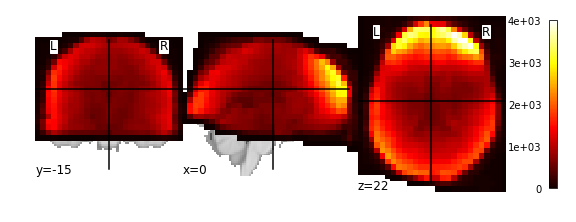

In [35]:
from nilearn import plotting
from nilearn.image import mean_img
import matplotlib.pyplot as plt

plt.close()
plotting.plot_stat_map(mean_img(ds_img))
plt.show()

In [65]:
df.head()

,resolution,sampling_rate,mean_cv_r2,mean_cv_mae,mean_test_r2,mean_test_mae,max_cv_r2,min_cv_mae,max_test_r2,min_test_mae,tr
0,2,1,0.606783,0.31703,0.564554,0.357104,0.606783,0.31703,0.564554,0.357104,Regular
1,2,0.8,0.600378,0.322536,0.564401,0.324121,0.755317,0.276552,0.683815,0.267735,NaN
2,2,0.7,0.601834,0.32032,0.60706,0.310026,0.705446,0.268496,0.717973,0.257244,NaN
3,2,0.6,0.56908,0.331835,0.572143,0.324302,0.67918,0.285519,0.821214,0.216543,NaN
4,2,0.5,0.503397,0.358711,0.528174,0.344,0.642725,0.307132,0.682682,0.289469,NaN


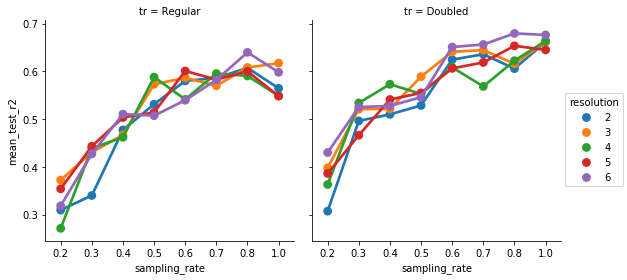

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.close()
sns.factorplot(x='sampling_rate',y='mean_test_r2', hue='resolution', col='tr',
              data=df)
plt.show()

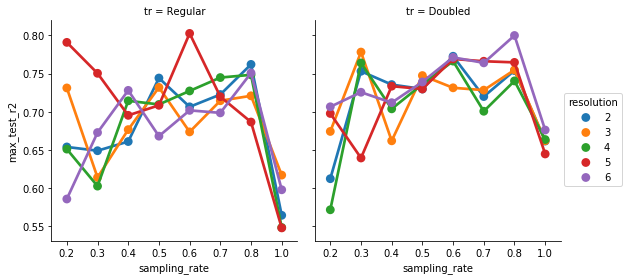

In [93]:
plt.close()
sns.factorplot(x='sampling_rate',y='max_test_r2', hue='resolution', col='tr',
              data=df)
plt.show()

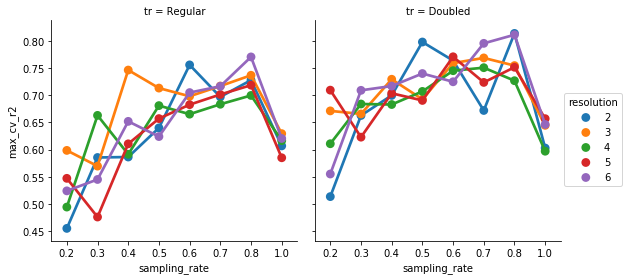

In [94]:
plt.close()
sns.factorplot(x='sampling_rate',y='max_cv_r2', hue='resolution', col='tr',
              data=df)
plt.show()

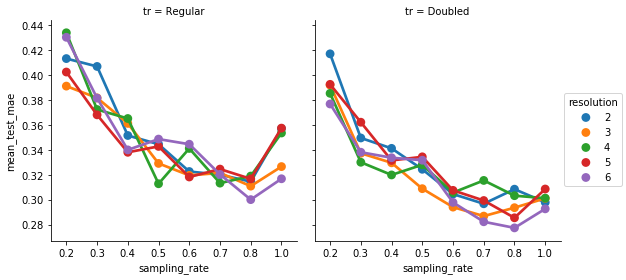

In [95]:
plt.close()
sns.factorplot(x='sampling_rate',y='mean_test_mae', hue='resolution', col='tr',
              data=df)
plt.show()

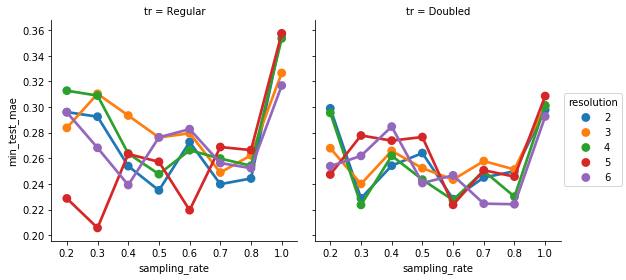

In [96]:
plt.close()
sns.factorplot(x='sampling_rate',y='min_test_mae', hue='resolution', col='tr',
              data=df)
plt.show()

In [14]:
df = pandas.read_csv('how_low_can_we_go.csv',index_col=0)

In [17]:
for ssize in df.sampling_rate.unique():
    for res in df.resolution.unique():
        demo_ind = df[(df.sampling_rate==ssize) & (df.resolution==res)].index[0]
        demo_subs = g_indices[demo_ind]
        X = np.load('%smm_features.npz'%res)['a'][demo_subs.values]
        y = np.log(pheno.loc[demo_subs,'Age'])
        ageGroup = pheno.loc[demo_subs,'AgeGroup']
        
        X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
        y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
            # scores
        r2 = r2_score(y_pred = y_pred, y_true = y_train)
        mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
        print('>>>SIZE=%s,RES=%smm<<<'%(ssize,res))
        print('validation r2: %s'%r2)
        print('validation mae: %s'%mae)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test) 
        r2 = clf.score(X_test, y_test)
        mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
        print('test r2: %s'%r2)
        print('test mae: %s'%mae)


>>>SIZE=1.0,RES=2mm<<<
validation r2: 0.6067900892749318
validation mae: 0.3171767357183989
test r2: 0.5645052266954728
test mae: 0.35719953873825666
>>>SIZE=1.0,RES=3mm<<<
validation r2: 0.6293467027252573
validation mae: 0.31071484308342184
test r2: 0.6171726624530482
test mae: 0.3265798917844498
>>>SIZE=1.0,RES=4mm<<<
validation r2: 0.61647637945984
validation mae: 0.314381028704409
test r2: 0.548596122684469
test mae: 0.35356228431460035
>>>SIZE=1.0,RES=5mm<<<
validation r2: 0.5849778040777571
validation mae: 0.3287474902604423
test r2: 0.548090452838556
test mae: 0.3574662847157747
>>>SIZE=1.0,RES=6mm<<<
validation r2: 0.6204414624378485
validation mae: 0.3135354612829246
test r2: 0.5979730221894721
test mae: 0.31680104488865984
>>>SIZE=0.8,RES=2mm<<<
validation r2: 0.7537006294097754
validation mae: 0.25569377931027526
test r2: 0.6377540806595507
test mae: 0.3039981949510079
>>>SIZE=0.8,RES=3mm<<<
validation r2: 0.76711839732992
validation mae: 0.24796474054677317
test r2: 0.5897

# Estimate size

In [229]:
from subprocess import check_output
output = check_output('ls -lrth ~/Science/Nilearn_tutorial/ds000028/ds000228/*.nii.gz',
                      shell=True)

In [246]:
sizes = [str(output).split('M Sep')[x][-2:] for x in range(len(str(output).split('M Sep')))]
sizes = [int(x) for x in sizes if x.isnumeric()]
len(sizes)

155

In [252]:
from math import isclose
[x for x in range(len(sizes)) if isclose(sizes[x],np.mean(sizes),abs_tol=1)] 

[34, 37, 41, 43, 46, 48, 51, 52, 56, 59, 66, 70, 90, 97, 101, 102, 108]

In [253]:
print(np.mean(sizes), sizes[34])

81.90967741935484 82


In [112]:
from nilearn.image import crop_img

size_test_ind = 34
size_test_sub = data.func[34]

for double_tr in [False,True]:
    if double_tr:
        size_test_sub, conf = double_TR(size_test_sub, size_test_ind)
        addon = 'doubledTR'
    else:
        conf = prepare_confounds(data.confounds[size_test_ind])
        addon = ''
    for reduction in range(2,6):
        sshape = [int(round(x)) for x in np.array(ex.shape[:3]
                                                 ) / reduction]
        #downsampling_args.update({'target_shape': sshape})
        downsampling_args.update({'target_shape': None})
        aff_mat = ex.affine
        factor = 2+(reduction-1)
        aff_mat[0,0] = factor*-1
        aff_mat[1,1] = factor
        aff_mat[2,2] = factor
        downsampling_args.update({'target_affine': aff_mat})
        downsampling_args.update({'target_type': np.float32})
        ds_img = reduce_data(img_path=size_test_sub,
                         target_affine=downsampling_args['target_affine'][:3,:3],
                         target_shape = None,
                         target_type = downsampling_args['target_type'])
        ds_img = crop_img(ds_img)
        ds_img.to_filename('%smm_test_sub%s'%(factor,addon))
        print('finished',factor)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


finished 3


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


finished 4


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


finished 5


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


finished 6


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


finished 3


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


finished 4


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


finished 5


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


finished 6


In [113]:
from subprocess import check_output
output = check_output('ls -lrth ~/git/RS2018_Nilearn_tutorial/development/*.nii',
                      shell=True)
output

b'-rw-r----- 1 jvogel jvogel 100M Nov 20 18:43 /home/users/jvogel/git/RS2018_Nilearn_tutorial/development/3mm_test_sub.nii\n-rw-r----- 1 jvogel jvogel  44M Nov 20 18:43 /home/users/jvogel/git/RS2018_Nilearn_tutorial/development/4mm_test_sub.nii\n-rw-r----- 1 jvogel jvogel  24M Nov 20 18:44 /home/users/jvogel/git/RS2018_Nilearn_tutorial/development/5mm_test_sub.nii\n-rw-r----- 1 jvogel jvogel  14M Nov 20 18:44 /home/users/jvogel/git/RS2018_Nilearn_tutorial/development/6mm_test_sub.nii\n-rw-r----- 1 jvogel jvogel  50M Nov 20 18:44 /home/users/jvogel/git/RS2018_Nilearn_tutorial/development/3mm_test_subdoubledTR.nii\n-rw-r----- 1 jvogel jvogel  22M Nov 20 18:44 /home/users/jvogel/git/RS2018_Nilearn_tutorial/development/4mm_test_subdoubledTR.nii\n-rw-r----- 1 jvogel jvogel  12M Nov 20 18:44 /home/users/jvogel/git/RS2018_Nilearn_tutorial/development/5mm_test_subdoubledTR.nii\n-rw-r----- 1 jvogel jvogel 6.9M Nov 20 18:44 /home/users/jvogel/git/RS2018_Nilearn_tutorial/development/6mm_test_subd

In [262]:
sizes = dict(zip(range(3,7), [100, 43, 23, 14]))
sizes

{3: 100, 4: 43, 5: 23, 6: 14}

In [57]:
# WINNERS 
print('ssize = 0.3, res=6, SIZE = %s'%((155*0.3) * 14))
print('ssize = 0.4, res=5, SIZE = %s'%((155*0.4) * 23))
print('ssize = 0.5, res=6, SIZE = %s'%((155*0.5) * 14))
print('ssize = 0.6, res=6, SIZE = %s'%((155*0.6) * 14))
print('ssize = 0.7, res=6, SIZE = %s'%((155*0.7) * 14))

ssize = 0.3, res=6, SIZE = 1999.5
ssize = 0.4, res=5, SIZE = 1426.0
ssize = 0.5, res=6, SIZE = 1085.0
ssize = 0.6, res=6, SIZE = 1302.0
ssize = 0.7, res=6, SIZE = 1519.0


### An example subject to Nilearn's specifications (4mm, doubled TR, int16)

In [115]:
ni.load(data.func[0]).shape

(79, 95, 68, 168)

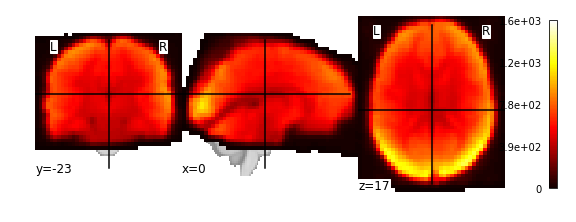

In [118]:
jnk = ni.load('4mm_test_subdoubledTR.nii')
plt.close()
plotting.plot_stat_map(mean_img(jnk))
plt.show()

In [139]:
(8.7 * 155)

1348.5

In [ ]:
(22 * 155)

In [137]:
0.40*155

62.0

# Make sure it actually works at low res

#### At Gaël's request, this next example is 30% of the sample resampled to 4mm, using ~2GB

In [67]:
demo_ind = df[(df.sampling_rate==0.3) & (df.resolution==4)].index[0]
demo_subs = g_indices[demo_ind]
X = np.load('6mm_features.npz')['a'][demo_subs.values]
y = pheno.loc[demo_subs,'Age']
ageGroup = pheno.loc[demo_subs,'AgeGroup']

In [68]:
print(demo_subs.tolist())

[144, 13, 112, 60, 4, 97, 130, 30, 22, 129, 16, 10, 53, 132, 121, 45, 83, 88, 59, 61, 41, 35, 66, 116, 90, 42, 77, 27, 9, 136, 141, 67, 79, 153, 33, 85, 154, 138, 108, 3, 80, 81, 147, 92, 40, 84]


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


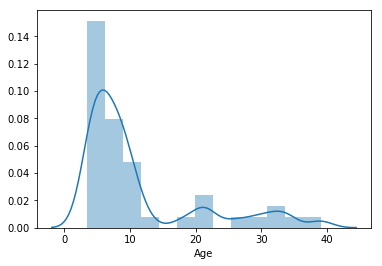

In [69]:
plt.close()
sns.distplot(y)
plt.show()

validation r2: 0.5636547978984686
validation mae: 4.597181898895248


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


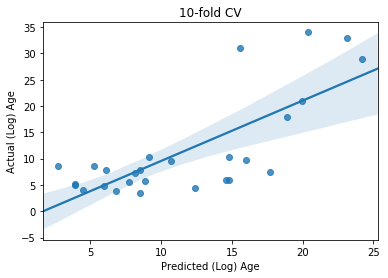

test r2: 0.5483501819291096
test mae: 4.95909517342879


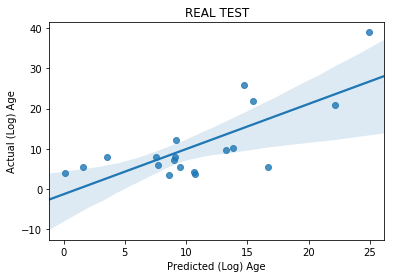

In [70]:
X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
    # scores
r2 = r2_score(y_pred = y_pred, y_true = y_train)
mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('validation r2: %s'%r2)
print('validation mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_train)
plt.title('10-fold CV')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
r2 = clf.score(X_test, y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print('test r2: %s'%r2)
print('test mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_test)
plt.title('REAL TEST')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

#### Here's another example after talking to the nilearn folks -- 40% of sample, 4mm, int, doubled-TR

In [126]:
demo_ind = df[(df.sampling_rate==0.4) & (df.resolution==4) & (df.tr=='Doubled')].index[0]
demo_subs = g_indices[demo_ind]
X = np.load('4mm_features_doubledTR.npz')['a'][demo_subs.values]
y = pheno.loc[demo_subs,'Age']
ageGroup = pheno.loc[demo_subs,'AgeGroup']

In [129]:
print(demo_subs.tolist())

[29, 30, 106, 89, 35, 78, 42, 84, 91, 116, 23, 82, 119, 126, 63, 10, 41, 121, 105, 81, 154, 149, 46, 94, 133, 100, 18, 136, 3, 80, 5, 43, 31, 69, 19, 110, 125, 124, 60, 48, 72, 24, 129, 79, 90, 137, 147, 98, 45, 117, 152, 57, 1, 150, 70, 120, 11, 55, 148, 37, 21, 36]


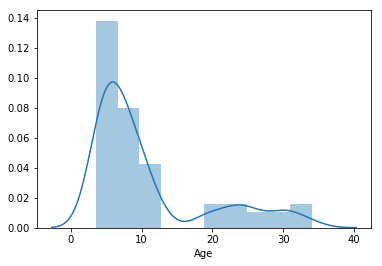

In [130]:
plt.close()
sns.distplot(y)
plt.show()

validation r2: 0.609621842673
validation mae: 4.29472359506


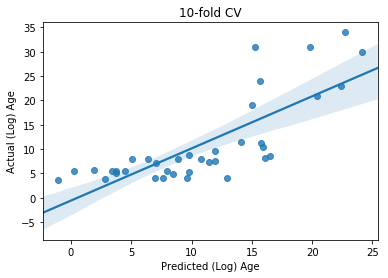

test r2: 0.651210209835
test mae: 3.43017658195


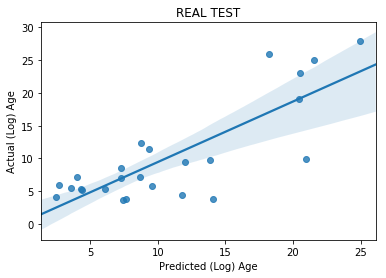

In [131]:
X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
    # scores
r2 = r2_score(y_pred = y_pred, y_true = y_train)
mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('validation r2: %s'%r2)
print('validation mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_train)
plt.title('10-fold CV')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
r2 = clf.score(X_test, y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print('test r2: %s'%r2)
print('test mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_test)
plt.title('REAL TEST')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

#### And assuming we can host zipped stuff... that's 100%

In [145]:
demo_ind = df[(df.sampling_rate==1) & (df.resolution==4) & (df.tr=='Doubled')].index[0]
demo_subs = g_indices[demo_ind]
X = np.load('4mm_features_doubledTR.npz')['a'][demo_subs.values]
y = pheno.loc[demo_subs,'Age']
ageGroup = pheno.loc[demo_subs,'AgeGroup']

In [141]:
print(demo_subs.tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]


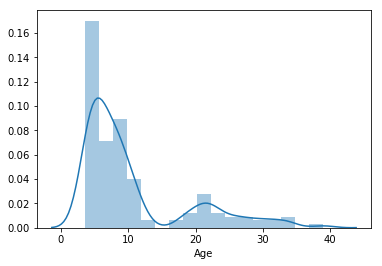

In [146]:
plt.close()
sns.distplot(y)
plt.show()

In [150]:
y.astype(int).value_counts().sort_index()

3     17
4     14
5     34
7     23
8     12
9      9
10     7
11     4
12     2
18     2
19     3
20     1
21     5
22     4
23     3
24     1
25     2
26     1
27     2
28     1
29     1
30     1
31     2
33     2
34     1
39     1
Name: Age, dtype: int64

validation r2: 0.496238784731
validation mae: 4.08032183737


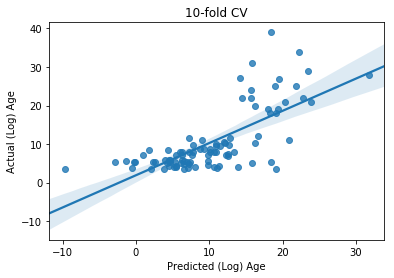

test r2: 0.591396582401
test mae: 3.7751855209


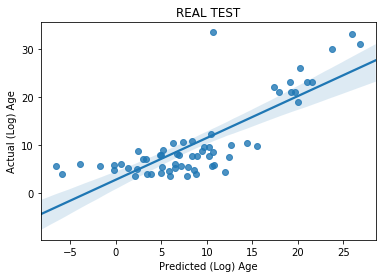

In [143]:
X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
    # scores
r2 = r2_score(y_pred = y_pred, y_true = y_train)
mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('validation r2: %s'%r2)
print('validation mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_train)
plt.title('10-fold CV')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
r2 = clf.score(X_test, y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print('test r2: %s'%r2)
print('test mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_test)
plt.title('REAL TEST')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

#### This example uses 30% of the sample and looks at images resampled to 6mm and uses ~0.65GB

In [62]:
demo_ind = df[(df.sampling_rate==0.3) & (df.resolution==6)].index[0]
demo_subs = g_indices[demo_ind]
X = np.load('6mm_features.npz')['a'][demo_subs.values]
y = pheno.loc[demo_subs,'Age']
ageGroup = pheno.loc[demo_subs,'AgeGroup']

In [63]:
print(demo_subs.tolist())

[24, 137, 3, 113, 128, 27, 72, 121, 142, 51, 135, 97, 80, 30, 54, 84, 43, 63, 36, 53, 29, 16, 35, 74, 12, 152, 102, 62, 71, 89, 141, 105, 106, 50, 83, 145, 99, 22, 129, 124, 118, 55, 133, 9, 100, 96]


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


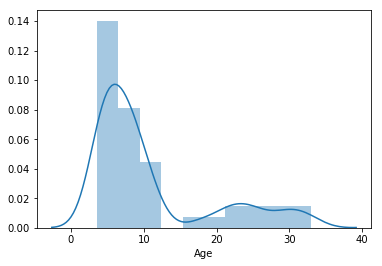

In [64]:
plt.close()
sns.distplot(y)
plt.show()

validation r2: 0.6730991187268387
validation mae: 4.2582832982173935


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


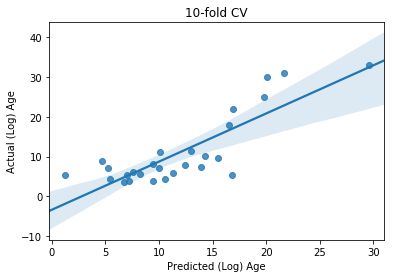

test r2: 0.5280081928722693
test mae: 4.431180944765598


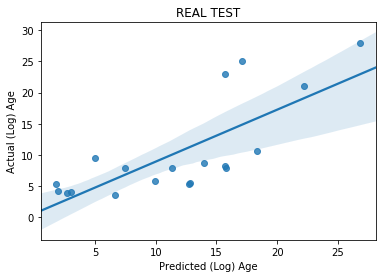

In [65]:
X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
    # scores
r2 = r2_score(y_pred = y_pred, y_true = y_train)
mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('validation r2: %s'%r2)
print('validation mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_train)
plt.title('10-fold CV')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
r2 = clf.score(X_test, y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print('test r2: %s'%r2)
print('test mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_test)
plt.title('REAL TEST')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

#### This next example uses 70% of the sample resampled to 6mm and uses ~1.5GB

In [53]:
demo_ind = df[(df.sampling_rate==0.7) & (df.resolution==6)].index[0]
demo_subs = g_indices[demo_ind]
X = np.load('6mm_features.npz')['a'][demo_subs.values]
y = pheno.loc[demo_subs,'Age']
ageGroup = pheno.loc[demo_subs,'AgeGroup']

In [54]:
print(demo_subs.tolist())

[20, 59, 22, 98, 143, 8, 1, 118, 114, 84, 9, 38, 132, 4, 80, 151, 63, 146, 137, 11, 14, 29, 69, 7, 153, 25, 136, 13, 79, 71, 31, 55, 12, 124, 10, 42, 109, 50, 34, 135, 90, 64, 52, 70, 85, 5, 142, 100, 102, 44, 32, 106, 152, 96, 119, 99, 89, 127, 101, 33, 123, 147, 72, 94, 105, 126, 49, 103, 154, 66, 128, 27, 51, 61, 6, 138, 19, 111, 115, 56, 81, 48, 120, 95, 60, 104, 15, 129, 113, 0, 67, 77, 149, 87, 37, 139, 3, 36, 83, 54, 75, 53, 140, 17, 39, 107, 150, 110]


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


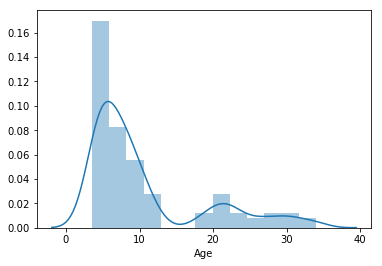

In [55]:
plt.close()
sns.distplot(y)
plt.show()

validation r2: 0.7070494096184632
validation mae: 3.513103296633346


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


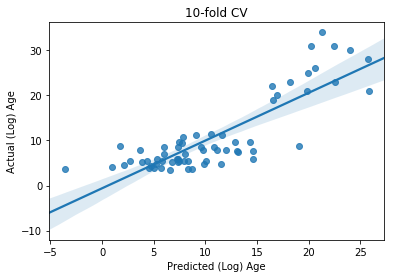

test r2: 0.4508091741724133
test mae: 4.415805499249816


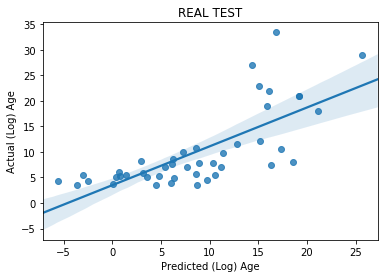

In [56]:
X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
    # scores
r2 = r2_score(y_pred = y_pred, y_true = y_train)
mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('validation r2: %s'%r2)
print('validation mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_train)
plt.title('10-fold CV')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
r2 = clf.score(X_test, y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print('test r2: %s'%r2)
print('test mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_test)
plt.title('REAL TEST')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()